In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs, reset_tf_graph

import tf_lab.point_clouds.in_out as pio
from tf_lab.point_clouds.in_out import PointCloudDataSet, write_model_ids_of_datasets
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf
import tf_lab.point_clouds.encoders_decoders as enc_dec

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id, match_incomplete_to_complete_data

from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed, \
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch, \
                                                  plot_interpolations
                                                  


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from general_tools.simpletons import select_first_last_and_k
from geo_tool import Point_Cloud

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)


%matplotlib inline
%load_ext autoreload
%autoreload 2

Loading manual conv_3d_transpose.
External Losses (Chamfer-EMD) cannot be loaded.
Loading manual conv_3d_transpose.


In [6]:
experiment_name = 'debug'

do_training = False
do_plotting = False

seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

full_pclouds_path = '/Users/optas/DATA/Point_Clouds/Shape_Net_Core/from_manifold_meshes/1024/03001627/'

train_dir = osp.join('/Users/optas/Desktop/')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/Users/optas/Desktop/debug'

In [8]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_file_names = full_file_names[:300]
full_pclouds, full_model_names, full_syn_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=4)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

300 files containing complete point clouds were found.


In [17]:
train_data_, val_data_, test_data_, r_indices = pio.train_validate_test_split([full_pclouds, 
                                                                    full_model_names],
                                                                    train_perc=0.85,
                                                                    validate_perc=0.05,
                                                                    test_perc=0.1,                                                                   
                                                                    seed=seed)

model_ids = np.vstack((full_model_names, full_syn_ids)).T
write_model_ids_of_datasets(train_dir, model_ids, r_indices)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [26]:
reset_tf_graph()

n_input = [1024, 3]

decoder_args = {'layer_sizes': [1024, np.prod(n_input)], 
                'non_linearity': tf.nn.relu, 
                'b_norm': False
               }

encoder_args = {'b_norm': False, 'spn': False, 'symmetry': tf.reduce_sum}

experiment_name = 'test'
 
conf = Conf(
            n_input = n_input,
            training_epochs = 5,
            batch_size = 5,
            loss = 'l2',
            train_dir = train_dir,
            loss_display_step = 1,
            saver_step = 1,
            learning_rate = 0.00002,
            saver_max_to_keep = 100,
            gauss_augment = {'mu': 0, 'sigma': 0.02},
            
            encoder = enc_dec.encoder_with_convs_and_symmetry,
            encoder_args = encoder_args,
            decoder = enc_dec.decoder_with_fc_only,
            decoder_args = decoder_args,
            experiment_name = experiment_name
           )


ae = PointNetAutoEncoder('test', conf)

In [27]:
# ae.train(train_data, conf)
saved_epochs = read_saved_epochs(conf.train_dir)
ae.restore_model(train_dir, saved_epochs[-1])

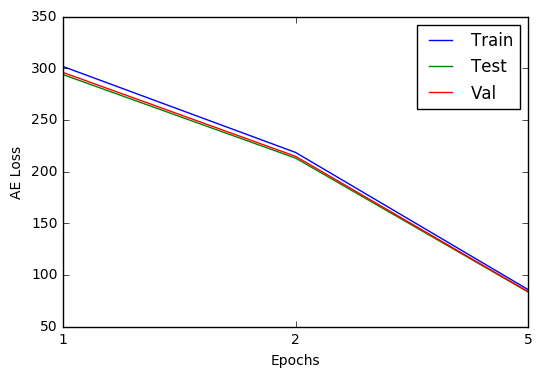

In [33]:
# val_data.num_examples
if True:
    saved_epochs = read_saved_epochs(conf.train_dir)
    plot_epochs = select_first_last_and_k(saved_epochs, 1)
    stats = eval_model(ae, conf, [train_data, val_data, test_data], epochs=plot_epochs)
    last_epoch = saved_epochs[-1]
    top_save_dir = osp.join(conf.train_dir, 'model_evaluation')    
    plot_train_val_test_curves(stats, top_save_dir, has_validation=True, best_epoch=None, show=True)    
    
    save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=250)
    save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(last_epoch))
    plot_reconstructions_at_epoch(last_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=250)